# 0) Libraries Import

In [104]:
import pandas as pd
import numpy as np
import sklearn as sk
import xgboost as xgb
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
import warnings
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import GridSearchCV
import datetime as dt

warnings.filterwarnings("ignore")


# 1) Import data

Data was imported in its original format and will be processed for model input in the following steps. It is easy to devise data has been already pre-cleaned and its almost ready for modelling. Will perform some basic transformations to include presence of lags and information from the calendar. Every dataset will later be joined together into one final and unique datastet that will be used to train the models.

In [105]:
act_l0 = pd.read_excel('./Exercise - ACT and LO Monthly - FOR CANDIDATE-SENT - SHORT.xlsx')
daily_sales = pd.read_excel('./Exercise - Daily Sales - FOR CANDIDATE-SENT - SHORT.xlsx', sheet_name = None)['Daily Sales']
forecasts = pd.read_excel('Exercise - Forecasts - FOR CANDIDATE-SENT - SHORT.xlsx')
working_days = pd.read_excel('Exercise - Working Days calendar - FOR CANDIDATE-SENT - SHORT.xlsx', sheet_name=None)['Weekdays']
working_days_calendar = pd.read_excel('Exercise - Working Days calendar - FOR CANDIDATE-SENT - SHORT.xlsx', sheet_name=None)['Calendar']

# 2) Data Preprocessing

#### 2.1) Working Days

Data from working days dataset will be transforme to suit the needs of the project. In this case, features will be used to consider the effect stated in the project document where some days could be associated with higher activity for a specific branch or months. Ideally, the number of working days will also afect the result. One could expect months with relatively more working days should present a higher amount of sales.

In [106]:
#Drop empty rows at the begining of the dataset.
working_days = pd.DataFrame(working_days[4:])
#Rename columns with the names from the 5th row.
working_days.rename(columns={'Unnamed: 1':'date','Unnamed: 2':'n_mondays','Unnamed: 3':'n_tuesdays','Unnamed: 4':'n_wednesdays',
'Unnamed: 5':'n_thursdays','Unnamed: 6':'n_fridays','Unnamed: 7':'n_saturdays','Unnamed: 8':'n_sundays',
'Unnamed: 9':'n_weekdays','Unnamed: 10':'n_workingdays' }, inplace=True)
working_days.drop('Unnamed: 0', inplace = True, axis =1)
#Transform dates to datetime format and create monthly periods for each datapoint. This will be the unique label (KEY) for each point in this dataframe.
working_days['month'] = pd.DatetimeIndex(working_days['date']).month
working_days['year'] = pd.DatetimeIndex(working_days['date']).year
working_days['date'] = pd.to_datetime(working_days['date'])
working_days['month-year'] = working_days['date'].dt.to_period('M')
working_days.reset_index(inplace=True, drop=True)
working_days_calendar = pd.DataFrame(working_days_calendar[4:])
working_days_calendar.rename(columns={'Unnamed: 2':'date','Unnamed: 3':'day_name','Unnamed: 4':'year',
'Unnamed: 5':'month_number','Unnamed: 6':'month_name','Unnamed: 7':'day','Unnamed: 8':'holiday'}, inplace=True)
working_days_calendar.drop(['Unnamed: 0', 'Unnamed: 1' ], inplace = True, axis =1)
working_days_calendar['date'] = pd.to_datetime(working_days_calendar['date'])
working_days_calendar['day'] = pd.to_numeric(working_days_calendar['day'])
#Identify working days for the prediction step. Predictions will only be estimated for working days.
aux = working_days_calendar[working_days_calendar['holiday']==1]
#Filter original dataset to obtain the part associated with the training data. (Only include observations available before the prediction date)
days_to_predict = aux[aux['date']>'2017-10-31']
days_to_predict = days_to_predict[days_to_predict['day'].between(15,25)]

#### 2.2) Actual and L0

This dataset contains the variable to predic (Actual) and the closest available estimate (L0). Records older than the prediction date will be treated differently than those available after the prediction.

In [107]:
#Filter actual data to separate it from L0 data.
actual = act_l0[act_l0['Submission']=='Actual']
actual.rename(columns={'Country 1 - Brand A':'Actual'},inplace = True)
actual.drop(['Submission'], inplace=True, axis=1)
#Filter L0 data to separate it from Actual data.
l0 = act_l0[act_l0['Submission']!='Actual']
l0.reset_index(inplace = True, drop=True)
l0.rename(columns = {'Country 1 - Brand A':'L0'},inplace = True)
l0.drop(['Submission','Year','Month'],inplace = True,axis = 1)
#Join both auxiliary datasets to include L0 and Actual values in two separate columns.
actual = pd.concat([actual,l0], axis=1)
#Hardcode keys for dates to predict since those where not available in the dataset.
actual.iloc[34,0] = 2017
actual.iloc[35,0] = 2017
actual.iloc[36,0] = 2018
actual.iloc[37,0] = 2018
actual.iloc[34,1] = 11
actual.iloc[35,1] = 12
actual.iloc[36,1] = 1
actual.iloc[37,1] = 2
actual['Year'] = actual['Year'].astype(int)
actual['Month'] = actual['Month'].astype(int)
#Create lags for the L0 variable. Will use the current and the t-1 L0 values to predict.
actual['L0-1'] = actual[['L0']].shift(periods=1)
actual['Month-Year'] = pd.PeriodIndex(actual['Year'].astype(str) + '-' + actual['Month'].astype(str), freq = 'M')

#### 2.3) Daily Sales

Daily sales will be treated independently for those days previous to the prediction months (where metrics will be taken monthly) and those days during the prediction months (where metrics will only be considered if available before the prediction date).
It was decided that Actuals will be predicted in every working day after the 14th of each month meaning several predictions will be provided for each months. 
Each prediction date will be treated as a new datapoint to predict. Here there could be some problems because the frequency changes, but since the problem is approached as a regression one, it is reasonable to follow this approach.

In [108]:
#Transform dates to corresponding format and create auxiliary variables for year, months and days.
daily_sales['Posting Date'] = pd.to_datetime(daily_sales['Posting Date'],format='%d.%m.%Y')
daily_sales['Posting Month'] = daily_sales['Posting Date'].dt.year
daily_sales['Posting Year'] = daily_sales['Posting Date'].dt.month
daily_sales['Posting Day'] = daily_sales['Posting Date'].dt.day
daily_sales['Month-Year'] = daily_sales['Posting Date'].dt.to_period('M')
#Drop columns since all the data belongs to the same country for the same brand.
daily_sales.drop(['Country','Brand'],axis=1, inplace = True) 
#Create monthly sums of daily sales to match dataset to predict (actuals should be handled monthly).
monthly_sales = daily_sales.groupby(by='Month-Year').agg({'Daily Sales':'sum'})
monthly_sales.rename(columns={'Daily Sales':'Total Sales'},inplace=True)
monthly_sales.reset_index(inplace=True, drop=False)
#Create monthly averages of daily sales to match dataset to predict (actuals should be handled monthly).
avg_sales = daily_sales.groupby(by='Month-Year').agg({'Daily Sales':'mean'})
avg_sales.reset_index(inplace=True, drop = True)
monthly_sales = pd.concat([monthly_sales,avg_sales],axis=1)
monthly_sales.rename(columns={'Daily Sales':'Avg Sales'},inplace=True)
monthly_sales = monthly_sales[monthly_sales['Month-Year']<'2017-11']
monthly_sales['month'] = pd.PeriodIndex(monthly_sales['Month-Year'],freq='M')

#Calculate monthly averages and totals for predictions date for every working day after the 14th of each month. 
#Each iteration will add a new data point (the next working day) and recalculate the metrics.
for date in days_to_predict['date']:
    aux_date = date.to_period('M')
    aux = daily_sales[daily_sales['Posting Date'].between(pd.to_datetime(str(aux_date)),date)]
    #print(min(aux['Posting Date']),max(aux['Posting Date']),len(aux['Posting Date']),date)
    avg = aux.groupby(by='Month-Year').agg({'Daily Sales':'mean'}).values[0][0]
    sum = aux.groupby(by='Month-Year').agg({'Daily Sales':'sum'}).values[0][0]
    monthly_sales = monthly_sales.append({'Month-Year':date,'Total Sales':sum, 'Avg Sales':avg,'month':aux_date}, ignore_index=True)

#Create t-1 lags for the two metrics to include time-series alike treatment.
monthly_sales['Avg Sales-1'] = monthly_sales['Avg Sales'].shift(periods=1)
monthly_sales['Total Sales-1'] = monthly_sales['Total Sales'].shift(periods=1)

#### 2.4) Final Dataset

Merge final dataset and drop columns that should not be considered for final prediction such as keys or duplicated columns due to the merge function.

In [109]:
final_data = monthly_sales.merge(working_days,how='left', left_on='month', right_on='month-year')
final_data = final_data.merge(actual, how='left',left_on='month_x', right_on='Month-Year')
final_data.drop(['month_y','Month-Year_y','Year','Month-Year_y','year','month_x','date'],axis = 1, inplace=True)
final_data = final_data[1:]
final_data.reset_index(inplace=True, drop=True)

In [110]:
training_set_x = final_data[final_data['month-year']<'2017-11'].drop(['Total Sales','Actual','month-year','Month-Year_x'],axis=1)
training_set_y = final_data[final_data['month-year']<'2017-11']['Actual']
to_predict = final_data[final_data['month-year']>='2017-11']
months_to_predict = to_predict['Month-Year_x']
to_predict.drop(['Total Sales','Actual','month-year','Month-Year_x'],axis=1,inplace=True)
print(training_set_x.shape,training_set_y.shape,to_predict.shape)

(33, 15) (33,) (28, 15)


Variables were treated as categoricals and a binary encoder approach was decided. Target encoding variables by the average of actuals could also have been an option but a simpler approach was decided considering the timeframe of data availability. 

Sklearn standard scaler was used to scale data for the model.

In [111]:
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

import category_encoders

encmonth = category_encoders.binary.BinaryEncoder(handle_unknown='ignore', handle_missing='ignore', drop_invariant=True)
training_set_x = encmonth.fit_transform(training_set_x, training_set_y)

scalerx = preprocessing.StandardScaler().fit(training_set_x)
training_set_x = scalerx.transform(training_set_x)
scalery = preprocessing.StandardScaler().fit(training_set_y.array.reshape(-1,1))
training_set_y = scalery.transform(training_set_y.array.reshape(-1,1))

#Last 4 observations were holded to perfrom basic training-test sets.
X = training_set_x[:29]
xtest = training_set_x[29:]
y = training_set_y[:29]
ytest = training_set_y[29:]

In [112]:
to_predict = encmonth.transform(to_predict)
to_predict = scalerx.transform(to_predict)

# 3) Modelling

Modelling had potentially two obvious approaches:
   1 - Treat data as a multi-timeseries problem and use a purely time-series approach following autoregression econometrics techniques such as ARIMA or GARCH.
   2 - Treat data as a typical regression problem and include lags as extra variables to add some time-series alike treatment.

It was decided to Bootstrap every model with re-sampling, disregarding the selected approach, to estimate the required 95% Confidence Intervals and % estimations for each prediction.

Approach number 2 was selected because it better suited the analyst's knowledge.

#### 3.1) XGBoost Regressor

A vanilla XGBoost Regressor model with Negative Root Mean Squared Error as evaluation metric  from SkLearn was used as first model to try and an extensive gridsearch was performed. Different parameter configurations are better explained in the code.

The best model was: XGBRegressor(alpha=1.0, base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1.0, enable_categorical=False,
             gamma=0.25, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.1, max_delta_step=0,
             max_depth=5, min_child_weight=0, missing=nan,
             monotone_constraints='()', n_estimators=1000, n_jobs=1, nthread=1,
             num_parallel_tree=1, predictor='auto', random_state=1337,
             reg_alpha=1, reg_lambda=1, scale_pos_weight=1, seed=1337,
             subsample=0.8, tree_method='exact', validate_parameters=1, ...)

Once this XGBoost model was chosen through 5-Folded GridSearch Cross-Validation, an ensemble bootstraped model was trained to reflect the uncertainty of predictions and estimate the 95% CI. 
For this purpose, 500 iterations were used.

According to information availabe online, CatBoost for Regression model could have also been tried.

In [113]:
from sklearn.model_selection import GridSearchCV

xgb_reg = xgb.XGBRegressor()
#Model and specified gridsearch.
parameters = {
        'nthread':[1], #when use hyperthread, xgboost may become slower
        'learning_rate': [0.001, 0.01, 0.1],
        'max_depth': [5, 10, 15],
        'subsample': [0.8],
        'colsample_bytree': [0.8, 1.0],
        'min_child_weight': [0,25,0.5], #also tried with 1.0
        'gamma': [0.25,1.0,3.0],
        'n_estimators': [300,500,700,1000],
        'alpha': [1.0,3.0], #also tried not penalizating with 0.0001
        'seed': [1337]}

model = GridSearchCV(xgb_reg,param_grid=parameters,n_jobs=7,cv=5,verbose=3, scoring='neg_root_mean_squared_error')

model.fit(X,y)

Fitting 5 folds for each of 1296 candidates, totalling 6480 fits
[CV 2/5] END alpha=1.0, colsample_bytree=0.8, gamma=0.25, learning_rate=0.001, max_depth=5, min_child_weight=0, n_estimators=300, nthread=1, seed=1337, subsample=0.8;, score=-1.104 total time=   0.1s
[CV 4/5] END alpha=1.0, colsample_bytree=0.8, gamma=0.25, learning_rate=0.001, max_depth=5, min_child_weight=0, n_estimators=300, nthread=1, seed=1337, subsample=0.8;, score=-0.482 total time=   0.1s
[CV 3/5] END alpha=1.0, colsample_bytree=0.8, gamma=0.25, learning_rate=0.001, max_depth=5, min_child_weight=0, n_estimators=300, nthread=1, seed=1337, subsample=0.8;, score=-0.662 total time=   0.1s
[CV 1/5] END alpha=1.0, colsample_bytree=0.8, gamma=0.25, learning_rate=0.001, max_depth=5, min_child_weight=0, n_estimators=300, nthread=1, seed=1337, subsample=0.8;, score=-1.580 total time=   0.2s
[CV 5/5] END alpha=1.0, colsample_bytree=0.8, gamma=0.25, learning_rate=0.001, max_depth=5, min_child_weight=0, n_estimators=300, nthre

GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None,
                                    enable_categorical=False, gamma=None,
                                    gpu_id=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, max_delta_step=None,
                                    max_depth=None, min_child_weight=None,
                                    missing=nan, monotone_constraints=None,
                                    n...
                                    subsample=None, tree_method=None,
                                    validate_parameters=None, verbosity=None),
             n_jobs=7,
             param_grid={'alpha': [1.0, 3.0], 'colsample_bytree': [0.8, 1.0],
      

In [128]:
#Transform the performance metric back into the original values by inverse-transforming the scaler.
scalery.inverse_transform(model.best_score_.reshape(1,-1))

array([[248042.28533231]])

In [115]:
#Visualize the best estimator
model.best_estimator_

XGBRegressor(alpha=1.0, base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1.0, enable_categorical=False,
             gamma=0.25, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.1, max_delta_step=0,
             max_depth=5, min_child_weight=0, missing=nan,
             monotone_constraints='()', n_estimators=1000, n_jobs=1, nthread=1,
             num_parallel_tree=1, predictor='auto', random_state=1337,
             reg_alpha=1, reg_lambda=1, scale_pos_weight=1, seed=1337,
             subsample=0.8, tree_method='exact', validate_parameters=1, ...)

In [116]:
#Perform bagging to obtain 500 different models, trained in randomnly sampled datasets to obtain prediction confidence intervals.
from sklearn.ensemble import BaggingRegressor
estimators = 500

bagged_model = BaggingRegressor(model.best_estimator_, 
            n_estimators=estimators,bootstrap=True,verbose=3, n_jobs=7)

bagged_model.fit(X,y)

[Parallel(n_jobs=7)]: Using backend LokyBackend with 7 concurrent workers.


Building estimator 1 of 72 for this parallel run (total 500)...
Building estimator 1 of 72 for this parallel run (total 500)...
Building estimator 1 of 72 for this parallel run (total 500)...
Building estimator 1 of 71 for this parallel run (total 500)...
Building estimator 1 of 71 for this parallel run (total 500)...
Building estimator 2 of 72 for this parallel run (total 500)...
Building estimator 2 of 72 for this parallel run (total 500)...
Building estimator 1 of 71 for this parallel run (total 500)...
Building estimator 2 of 72 for this parallel run (total 500)...
Building estimator 1 of 71 for this parallel run (total 500)...
Building estimator 2 of 71 for this parallel run (total 500)...
Building estimator 2 of 71 for this parallel run (total 500)...
Building estimator 3 of 72 for this parallel run (total 500)...
Building estimator 3 of 72 for this parallel run (total 500)...
Building estimator 2 of 71 for this parallel run (total 500)...
Building estimator 3 of 72 for this para

[Parallel(n_jobs=7)]: Done   3 out of   7 | elapsed:   48.2s remaining:  1.1min
[Parallel(n_jobs=7)]: Done   7 out of   7 | elapsed:  1.0min finished


BaggingRegressor(base_estimator=XGBRegressor(alpha=1.0, base_score=0.5,
                                             booster='gbtree',
                                             colsample_bylevel=1,
                                             colsample_bynode=1,
                                             colsample_bytree=1.0,
                                             enable_categorical=False,
                                             gamma=0.25, gpu_id=-1,
                                             importance_type=None,
                                             interaction_constraints='',
                                             learning_rate=0.1,
                                             max_delta_step=0, max_depth=5,
                                             min_child_weight=0, missing=nan,
                                             monotone_constraints='()',
                                             n_estimators=1000, n_jobs=1,
                        

In [117]:
#Custom-built function to iterate through and record the 500 predictions from the 500 models.
def bagging(model,dataset,scaler):
    bagged_aux = pd.DataFrame()
    bagged_results = pd.DataFrame()
    i=0

    for m in model.estimators_:
        bagged_aux[i] = pd.DataFrame(scaler.inverse_transform(m.predict(dataset).reshape(-1,1)))
        i+=1
    #Calculate %std deviation and 95% upper and lower CI. For this purpose, normal distribuition of predictions was assumed.
    bagged_results['Avg Estimate'] = bagged_aux.mean(axis=1)
    bagged_results['Std'] = bagged_aux.std(axis=1)
    bagged_results['+/-'] = (bagged_results['Std']/bagged_results['Avg Estimate'])*100
    bagged_results['Upper CI'] = bagged_results['Avg Estimate'] + 1.96*bagged_results['Std']
    bagged_results['Lower CI'] = bagged_results['Avg Estimate'] - 1.96*bagged_results['Std']
    return bagged_results,bagged_aux

In [118]:
#Visualy compare results against test-set. This step does not imply any results over prediction accuracy.
predictions_xgb_test = pd.DataFrame()
predictions_xgb_test['pred'] = pd.DataFrame(scalery.inverse_transform(model.predict(xtest).reshape(-1,1)))
predictions_xgb_test['y'] = scalery.inverse_transform(ytest.reshape(-1,1))
predictions_xgb_test['difference'] = predictions_xgb_test['pred'] - predictions_xgb_test['y']

In [119]:
predictions_xgb_test

,pred,y,difference
0,324430.40625,295913.4,28517.00625
1,295568.12500,284361.4,11206.72500
2,283632.21875,275685.8,7946.41875
3,297932.93750,328168.2,-30235.26250


In [120]:
#Obtain results from 500-bagged model and save into a dataset. This is equivalent to the Forecasts excel file.
to_predict_results = pd.DataFrame(scalerx.inverse_transform(to_predict))
predictions,bagged_aux = bagging(bagged_model,to_predict,scalery)
to_predict_results = pd.concat([to_predict_results,predictions],axis=1)
months_to_predict.reset_index(inplace=True,drop=True)
to_predict_results['Period'] = months_to_predict

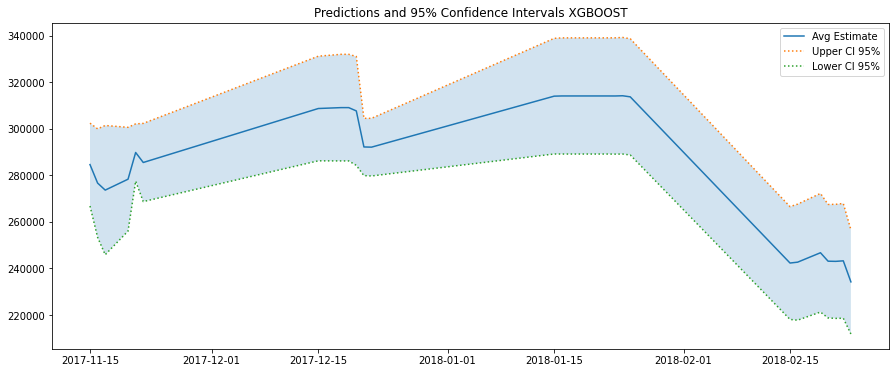

In [121]:
# Plot results and Confidence Intervals from the predictions
plt.figure(figsize=[15,6])
plt.plot(to_predict_results['Period'], to_predict_results['Avg Estimate'], label = "Avg Estimate")
plt.plot(to_predict_results['Period'], to_predict_results['Upper CI'], label = "Upper CI 95%",linestyle=":")
plt.plot(to_predict_results['Period'], to_predict_results['Lower CI'], label = "Lower CI 95%",linestyle=":")
plt.fill_between(to_predict_results['Period'], to_predict_results['Upper CI'],to_predict_results['Lower CI'], alpha=0.2)
plt.legend()
plt.title('Predictions and 95% Confidence Intervals XGBOOST')
plt.show()

#### 3.3) LSTM

A Long-Short Term Memory Neural Network as provided in the Keras package, with no customization, was also trained and evaluated in the prediction task. It is important to note that this type of models are mainly intended for larger datasets and some variance issues are expected.

Mean Squared Error was selected as loss function. When comparing results against the XGBOOST model, Root Mean Squared Error should be considered.

The LSTM NN was then bootstraped. For this purpose, a custom built function was employed since Keras models cannot be bagged as SkLearn models. 90% random samples were defined across 50 iterations resulting in 50 different trained models. This allowed to obtain the 95% CI and % variation metrics.

Prediction was then selected as the average of all the models for each datapoint.

In [122]:
data = pd.concat([pd.DataFrame(X),pd.DataFrame(y)],axis=1)

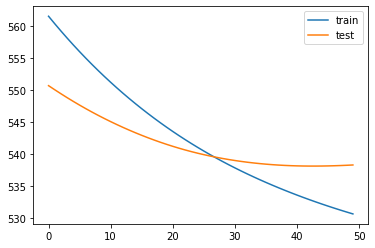

Iteration number 0


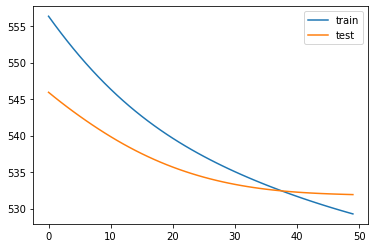

Iteration number 1


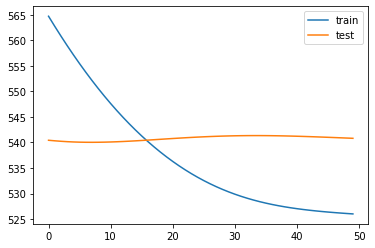

Iteration number 2


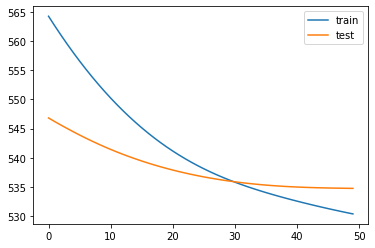

Iteration number 3


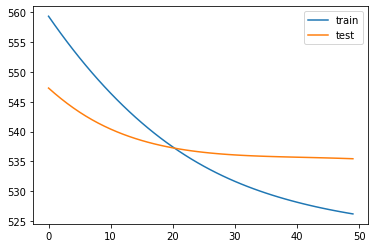

Iteration number 4


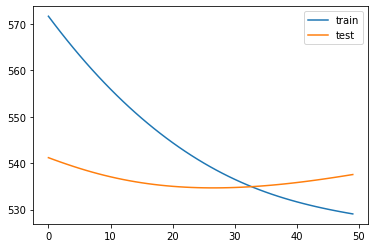

Iteration number 5


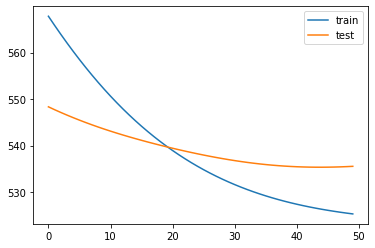

Iteration number 6


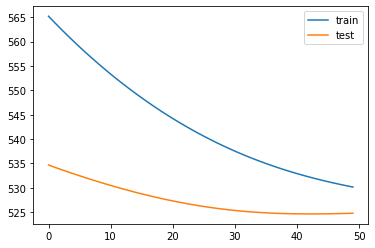

Iteration number 7


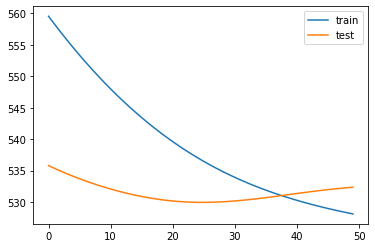

Iteration number 8


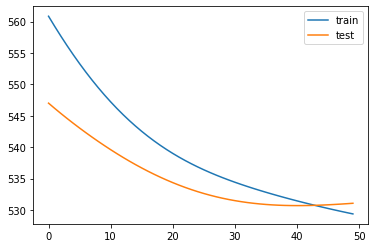

Iteration number 9


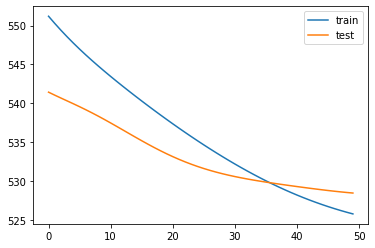

Iteration number 10


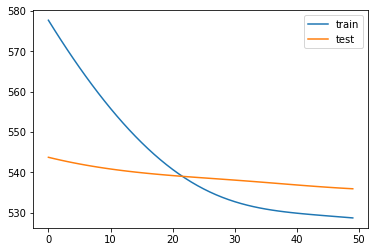

Iteration number 11


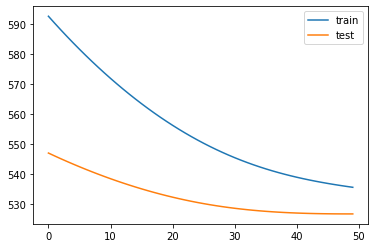

Iteration number 12


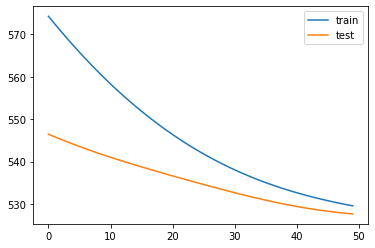

Iteration number 13


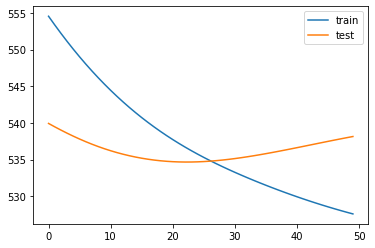

Iteration number 14


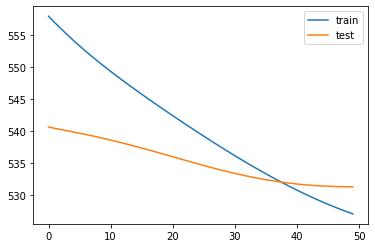

Iteration number 15


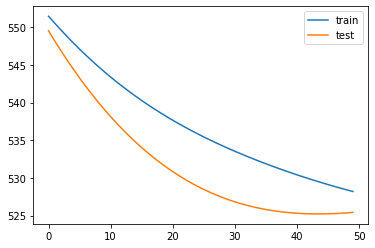

Iteration number 16


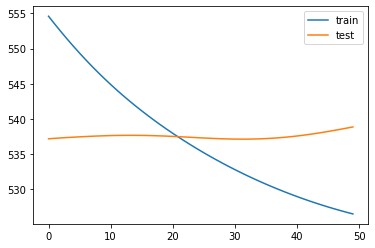

Iteration number 17


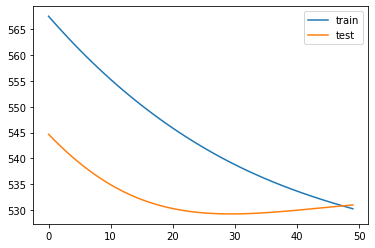

Iteration number 18


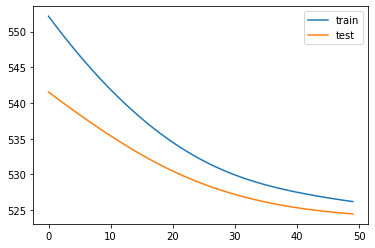

Iteration number 19


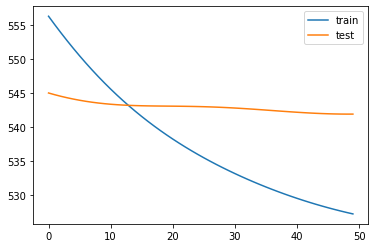

Iteration number 20


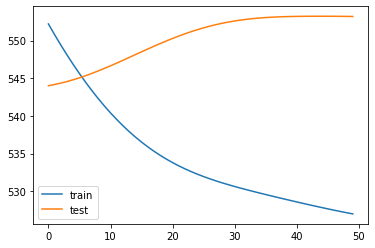

Iteration number 21


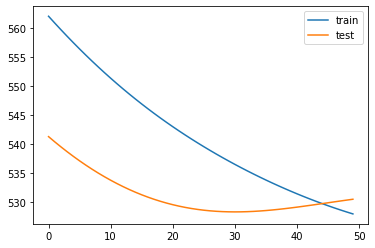

Iteration number 22


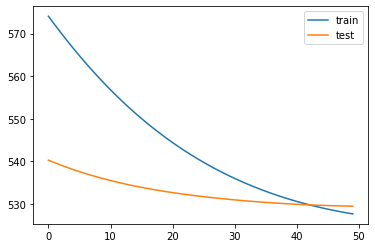

Iteration number 23


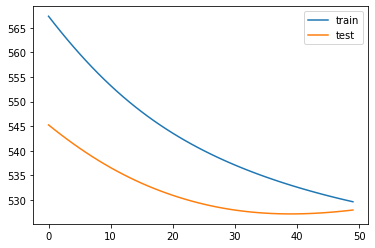

Iteration number 24


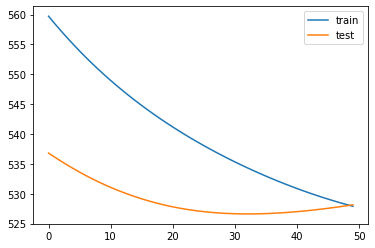

Iteration number 25


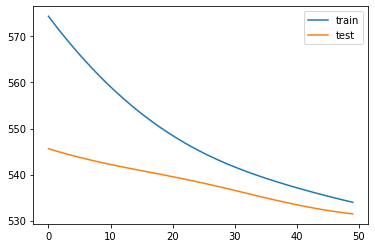

Iteration number 26


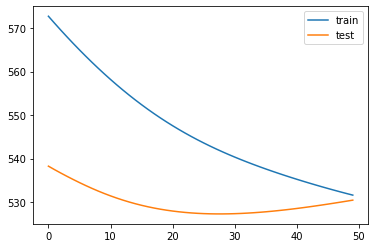

Iteration number 27


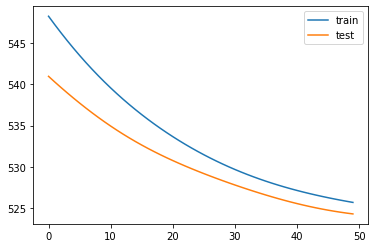

Iteration number 28


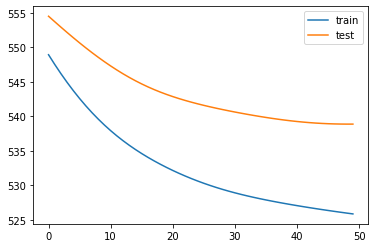

Iteration number 29


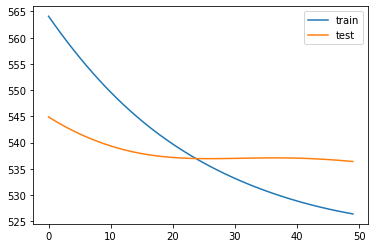

Iteration number 30


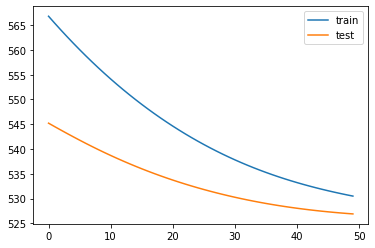

Iteration number 31


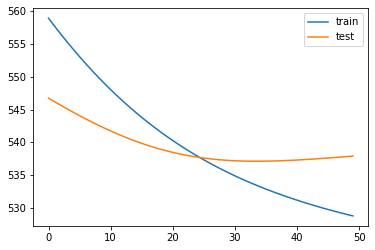

Iteration number 32


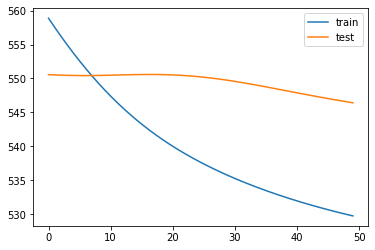

Iteration number 33


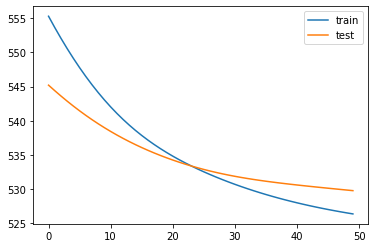

Iteration number 34


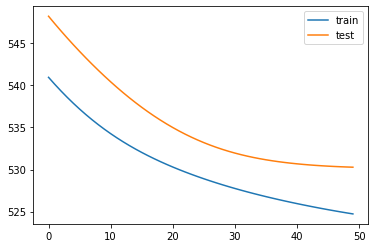

Iteration number 35


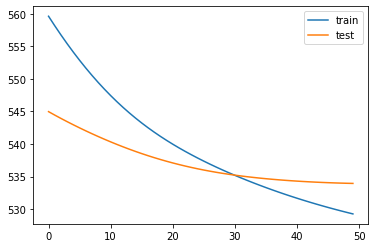

Iteration number 36


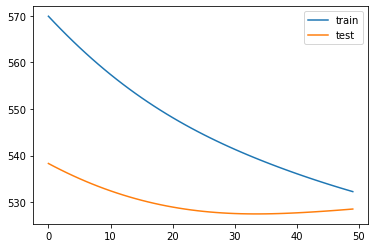

Iteration number 37


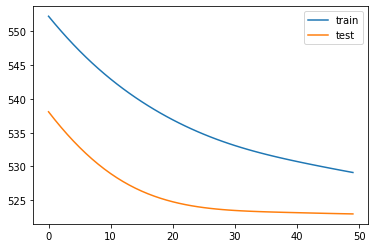

Iteration number 38


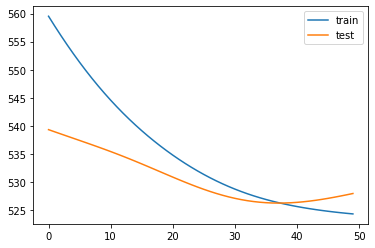

Iteration number 39


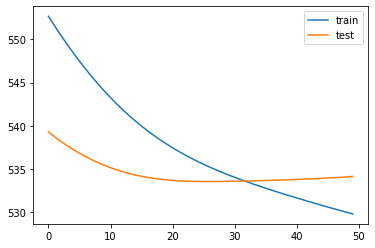

Iteration number 40


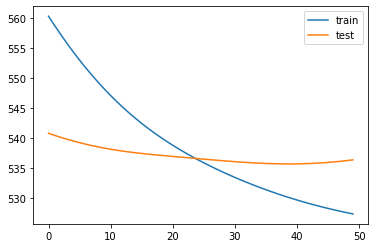

Iteration number 41


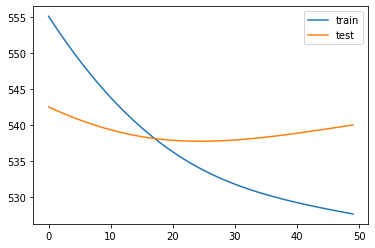

Iteration number 42


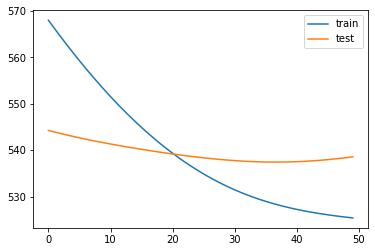

Iteration number 43


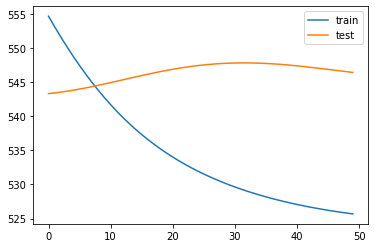

Iteration number 44


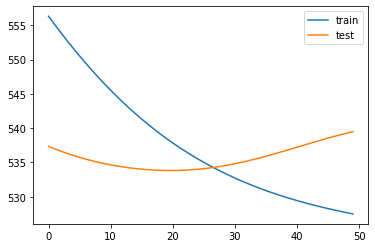

Iteration number 45


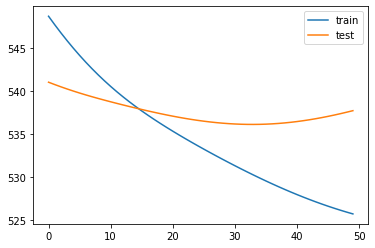

Iteration number 46


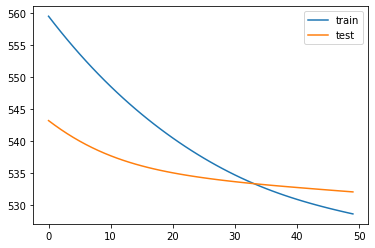

Iteration number 47


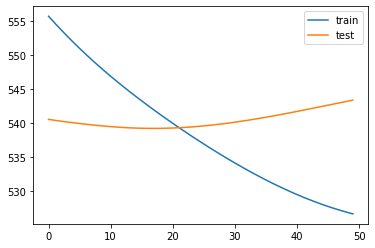

Iteration number 48


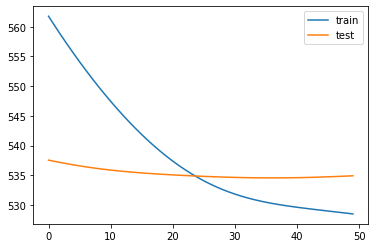

Iteration number 49


In [123]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
import tensorflow as tf 
from sklearn.utils import resample

iterations = 50
lstm_bagged = pd.DataFrame(months_to_predict)

for i in range(iterations):

    data_aux = pd.DataFrame(resample(data,n_samples = int(data.shape[0]*0.9), replace = True))
    X = np.array(data_aux.iloc[: , :-1])
    y = np.array(data_aux.iloc[:, [26]])

    #X=np.array(X)
    #y=np.array(y)

    trainingx = X.reshape((X.shape[0], 1, X.shape[1]))
    trainingy = y.reshape((y.shape[0], 1, y.shape[1]))
    testingx = xtest.reshape((xtest.shape[0], 1, xtest.shape[1]))
    testingy = ytest.reshape((ytest.shape[0], 1, ytest.shape[1]))

    lstm = Sequential()
    lstm.add(LSTM(50, input_shape=(trainingx.shape[1], trainingx.shape[2])))
    lstm.add(Dense(1))
    lstm.compile(loss=tf.keras.losses.MeanSquaredError(), optimizer='adam')
    # fit network
    history = lstm.fit(trainingx,trainingy, epochs=50, batch_size=72, validation_data=(testingx,testingy), verbose = 0, shuffle=False)
    
    # plot Loss across epochs. Squared Root was applied to the metric in order to compare it against XGBoost results.
    plt.plot(np.sqrt(scalery.inverse_transform(np.array(history.history['loss']).reshape(-1,1))), label='train')
    plt.plot(np.sqrt(scalery.inverse_transform(np.array(history.history['val_loss']).reshape(-1,1))), label='test')
    plt.legend()
    plt.show()

    lstm_to_predict = to_predict.reshape((to_predict.shape[0], 1, to_predict.shape[1]))
    predictions = lstm.predict(lstm_to_predict)
    lstm_bagged[f'result{i}'] = scalery.inverse_transform(predictions)
    print(f'Iteration number {i}')
    i+=1
    
lstm_bagged_results = pd.DataFrame()
lstm_bagged_results['Avg Estimate'] = lstm_bagged.mean(axis=1)
lstm_bagged_results['Std'] = lstm_bagged.std(axis=1)
lstm_bagged_results['+/-'] = (lstm_bagged_results['Std']/lstm_bagged_results['Avg Estimate'])*100
lstm_bagged_results['Upper CI'] = lstm_bagged_results['Avg Estimate'] + 1.96*lstm_bagged_results['Std']
lstm_bagged_results['Lower CI'] = lstm_bagged_results['Avg Estimate'] - 1.96*lstm_bagged_results['Std']
lstm_bagged_results['Period'] = months_to_predict


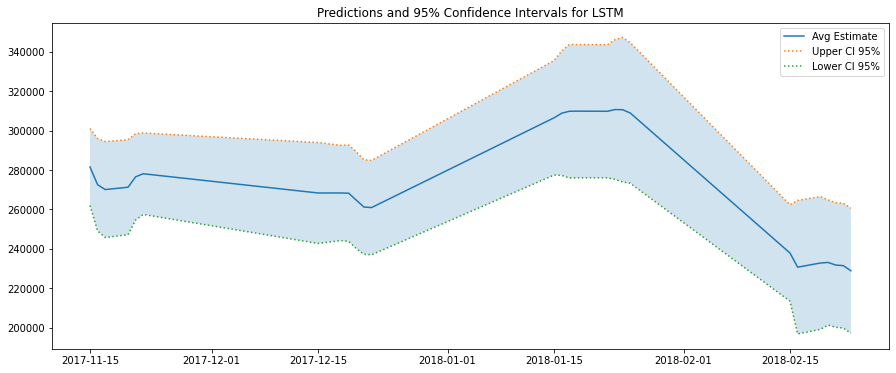

In [124]:
# plot lines
plt.figure(figsize=[15,6])
plt.plot(lstm_bagged_results['Period'], lstm_bagged_results['Avg Estimate'], label = "Avg Estimate")
plt.plot(lstm_bagged_results['Period'], lstm_bagged_results['Upper CI'], label = "Upper CI 95%",linestyle=":")
plt.plot(lstm_bagged_results['Period'], lstm_bagged_results['Lower CI'], label = "Lower CI 95%",linestyle=":")
plt.fill_between(lstm_bagged_results['Period'], lstm_bagged_results['Upper CI'],lstm_bagged_results['Lower CI'], alpha=0.2)
plt.legend()
plt.title('Predictions and 95% Confidence Intervals for LSTM')
plt.show()

# 4) Results

Analyzing the results, LSTM shows better prediction accuracy than XGBoost and results across different Bootstrap Iterations are more consistant. It is important to note that, regardless of  the results, XGBoost models are more widely knnow and accepted and are more suitable to smaller datasets than LSTM. 

Eventhough LSTM shows promising results, it is important to understand that given the few available datapoints, results can be missleading. Considering the Bias-Variance tradeoff, in this case, Variance could suppose an important problem and it is evident when analyzing the 95% CI's.

Results provided in the Forecast excel are those predicted from the LSTM model including the average predicted value across the Bootstrapped Models and the confidence intervales calculated from the same outputs.

Next steps:
    - Analyze ensemble methods considering results from both LSTM and XGBoost
    - Test wether CatBoost Regression could provide better results
    - Try a sequential model that takes as input the predicted values from t-1. For example, predict November 16th using November 15th predicted Actual.
    - Better understand the structure and basic feature importance analysis of the dataset.

In [129]:
lstm_bagged_results.to_excel('forecast.xlsx')

In [130]:
lstm_bagged_results

,Avg Estimate,Std,+/-,Upper CI,Lower CI,Period
0,281550.718750,9967.493164,3.540212,301087.00000,262014.437500,2017-11-15 00:00:00
1,272553.187500,11963.634766,4.389468,296001.90625,249104.468750,2017-11-16 00:00:00
2,270090.250000,12412.042969,4.595517,294417.84375,245762.640625,2017-11-17 00:00:00
3,271277.187500,12299.346680,4.533867,295383.90625,247170.468750,2017-11-20 00:00:00
4,276569.906250,11177.858398,4.041603,298478.50000,254661.296875,2017-11-21 00:00:00
5,278123.468750,10547.313477,3.792314,298796.18750,257450.734375,2017-11-22 00:00:00
6,268346.500000,13062.524414,4.867783,293949.06250,242743.953125,2017-12-15 00:00:00
7,268357.718750,12328.764648,4.594153,292522.09375,244193.343750,2017-12-18 00:00:00
8,268244.812500,12486.157227,4.654762,292717.68750,243771.937500,2017-12-19 00:00:00
9,264711.468750,12524.932617,4.731542,289260.34375,240162.593750,2017-12-20 00:00:00
